c:\Users\belen\anaconda3\Lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
c:\Users\belen\anaconda3\Lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
c:\Users\belen\anaconda3\Lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
c:\User

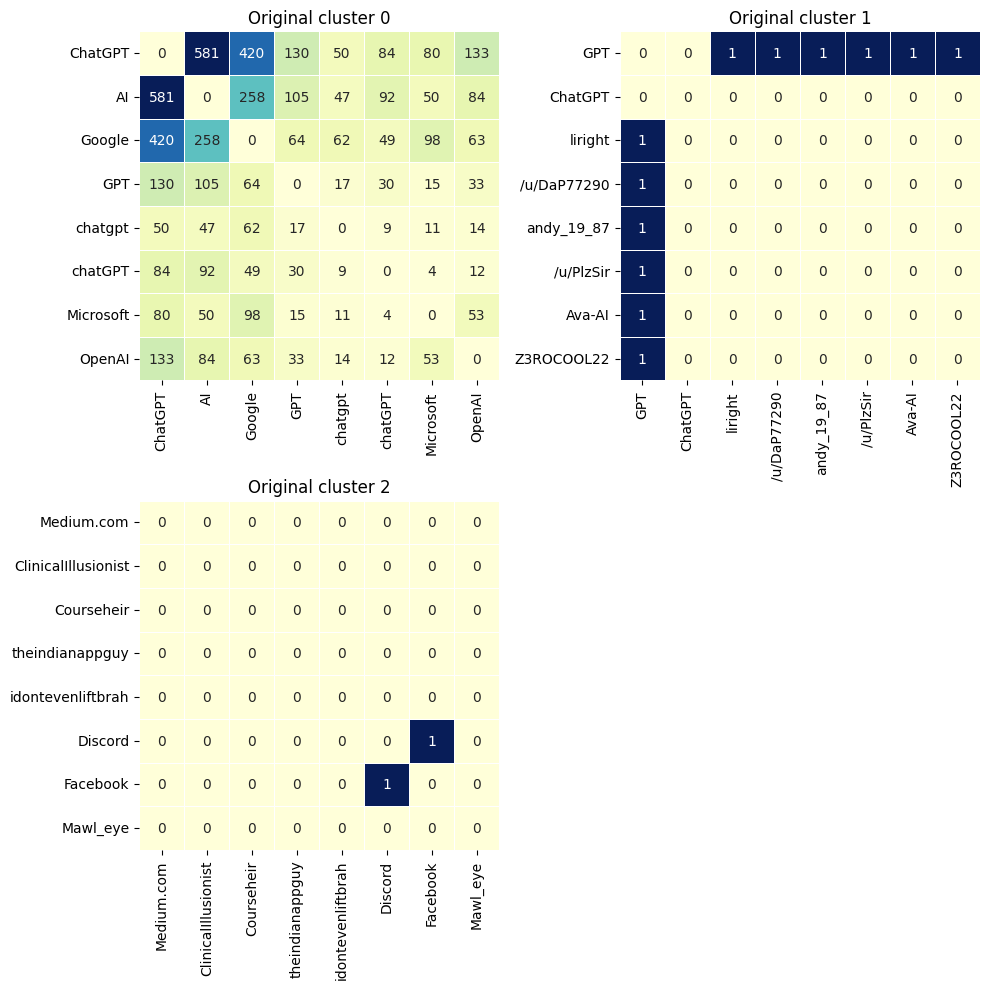

In [3]:
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations

# 0. Carga data con clusters
data = pd.read_csv('data/clustered_with_subclusters.csv')

nlp_ner = spacy.load("en_core_web_lg", disable=["parser","tagger"])
ENTITY_TYPES = {"PERSON","ORG","GPE","PRODUCT"}

# parámetros
topN = 8         # cuántas entidades top conservar
clusters = sorted(data['original_cluster'].unique())

# creamos un subplot grid
n_cols = 2
n_rows = int(np.ceil(len(clusters)/n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5))

for ax, cluster_id in zip(axes.flatten(), clusters):
    # 1) filtrar textos de ese cluster
    texts = data.loc[data.original_cluster == cluster_id, 'comment_body'].fillna("").tolist()
    
    # 2) extraer todas las entidades de interés
    records = []
    for txt in texts:
        doc = nlp_ner(txt)
        for ent in doc.ents:
            if ent.label_ in ENTITY_TYPES:
                records.append(ent.text)
    
    # 3) pillar las topN entidades
    top_entities = pd.Series(records).value_counts().head(topN).index.tolist()
    if not top_entities:
        ax.set_title(f"Orig cluster {cluster_id}\n(no entities)")
        ax.axis('off')
        continue
    
    # 4) construir co-ocurrencias entre esas top_entities
    co_counts = Counter()
    for txt in texts:
        doc = nlp_ner(txt)
        ents = {e.text for e in doc.ents if e.label_ in ENTITY_TYPES}
        subset = sorted(ents & set(top_entities))
        for a,b in combinations(subset, 2):
            co_counts[(a,b)] += 1
    
    # 5) llenar la matriz simétrica
    mat = pd.DataFrame(0, index=top_entities, columns=top_entities, dtype=int)
    for (a,b), cnt in co_counts.items():
        mat.loc[a,b] = cnt
        mat.loc[b,a] = cnt
    
    # 6) plot heatmap en el eje correspondiente
    sns.heatmap(
        mat, 
        ax=ax,
        cmap="YlGnBu",
        linewidths=0.5,
        cbar=False,
        annot=True,
        fmt="d"
    )
    ax.set_title(f"Original cluster {cluster_id}")
    ax.set_xlabel("")
    ax.set_ylabel("")

# si sobra algún eje vacío, lo ocultamos
for ax in axes.flatten()[len(clusters):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [4]:
import pandas as pd
import spacy

# 1. Cargar data y modelo NER
data    = pd.read_csv('data/clustered_with_subclusters.csv')
nlp_ner = spacy.load("en_core_web_lg", disable=["parser","tagger"])
ENTITY_TYPES = {"PERSON","ORG","GPE","PRODUCT"}

# 2. Extraer entidades a ner_df
records = []
for idx, text in enumerate(data['comment_body'].fillna("")):
    doc = nlp_ner(text)
    topic = data.loc[idx, 'original_cluster']
    sub    = data.loc[idx, 'subcluster']
    for ent in doc.ents:
        if ent.label_ in ENTITY_TYPES:
            records.append({
                "original_cluster": topic,
                "subcluster":       sub,
                "entity":           ent.text
            })

ner_df = pd.DataFrame(records)

# 3. (Opcional) guardarlo para no repetirlo después
ner_df.to_csv("data/ner_records.csv", index=False)
print("Saved ner_df with", len(ner_df), "rows → data/ner_records.csv")


c:\Users\belen\anaconda3\Lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Saved ner_df with 37772 rows → data/ner_records.csv


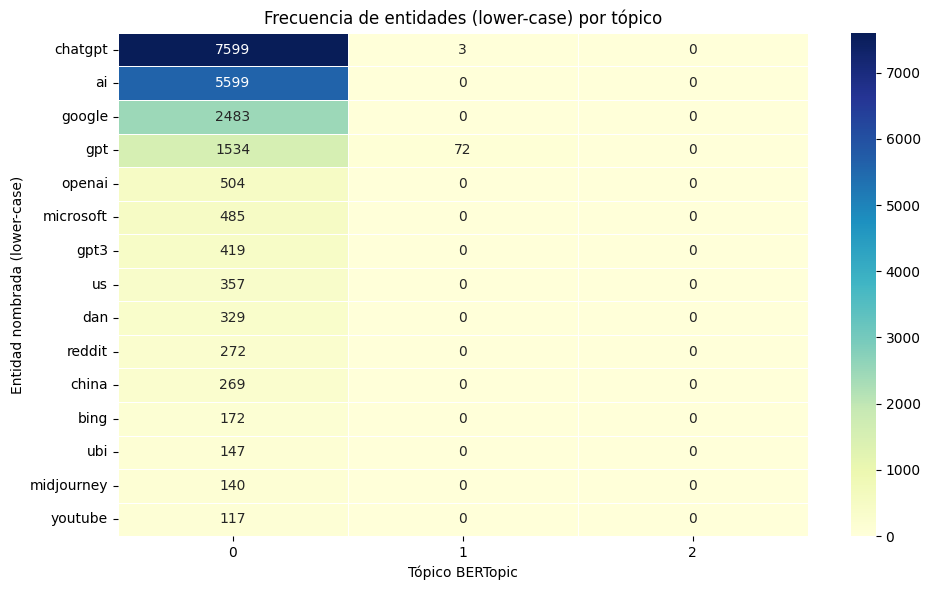

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Carga tu ner_df ya extraído
ner_df = pd.read_csv("data/ner_records.csv")

# 2. Normaliza a minúsculas y elimina espacios extra
ner_df["entity_norm"] = (
    ner_df["entity"]
      .str.lower()
      .str.strip()
      .str.replace(r"[^\w\s]", "", regex=True)  # opcional: quita puntuación
      .str.replace(r"\s+", " ", regex=True)
)

# 3. Vuelve a contar por tópico usando esta versión en minúsculas
freq = (
    ner_df
    .groupby(["original_cluster", "entity_norm"])
    .size()
    .reset_index(name="count")
)

# 4. Pivot a matriz y quedarnos con las top-15 entidades
mat = freq.pivot(index="entity_norm", columns="original_cluster", values="count").fillna(0)
mat["total"] = mat.sum(axis=1)
mat = mat.sort_values("total", ascending=False).head(15).drop(columns="total")

# 5. Dibuja heatmap
plt.figure(figsize=(10,6))
sns.heatmap(
    mat,
    cmap="YlGnBu",
    annot=True,
    fmt="g",
    linewidths=0.5
)
plt.title("Frecuencia de entidades (lower-case) por tópico")
plt.xlabel("Tópico BERTopic")
plt.ylabel("Entidad nombrada (lower-case)")
plt.tight_layout()
plt.show()
